In [1]:
import json
import numpy as np
import os
from typing import List, Dict, Any, Tuple

def load_experiment_data(filename: str) -> List[Dict[str, Any]]:
    """Reads JSONL file and returns a list of experiment dictionaries,
       handling string representations of infinity."""
    
    data_list = []
    
    #Custom function to convert string representations of infinity back to float
    def parse_infinity(value):
        if value == "inf":
            return float('inf')
        elif value == "-inf":
            return -float('inf')
        return value

    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return data_list

    with open(filename, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            try:
                #Load the JSON object
                data = json.loads(line)
                
                #Recursively parse through the dictionary to convert 'inf' strings
                def deep_parse(obj):
                    if isinstance(obj, dict):
                        return {k: deep_parse(v) for k, v in obj.items()}
                    elif isinstance(obj, list):
                        return [deep_parse(elem) for elem in obj]
                    elif isinstance(obj, str):
                        return parse_infinity(obj)
                    return obj
                
                data_list.append(deep_parse(data))
                
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON line: {e}")
    
    return data_list

In [5]:
def compare_apsp_results(a_star_data: List[Dict[str, Any]], bf_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Compares A* (heuristic) results against Bellman-Ford (ground truth)."""
    
    bf_map = {}
    
    #Map Bellman-Ford data by parameter key for quick lookup
    for bf_run in bf_data:
        p = bf_run['parameters']
        #Create a stable, hashable key (size, density, noise, neg_values)
        key = (p['size'], p['density'], p['noise_level'], p['negative_values'])
        bf_map[key] = bf_run

    comparison_results = []

    #Iterate through A* data and compare to the ground truth
    for a_star_run in a_star_data:
        p = a_star_run['parameters']
        key = (p['size'], p['density'], p['noise_level'], p['negative_values'])
        
        if key not in bf_map:
            #Skip if the corresponding ground truth run is missing
            continue

        bf_run = bf_map[key]
        a_star_paths = a_star_run['a_star_paths']
        bf_paths = bf_run['bellman_ford_paths']
        
        N = p['size']
        total_pairs = N * (N - 1)
        
        #Accuracy Metrics
        matched_costs = 0
        total_valid_paths = 0
        total_cost_diff = 0.0
        
        #Threshold for floating point comparison
        EPSILON = 1e-6 
        
        #Check every pair (s->d and d->s)
        for path_key in a_star_paths.keys():
            a_cost = a_star_paths[path_key]['cost']
            bf_cost = bf_paths.get(path_key, {'cost': float('nan')})['cost'] # Use .get() for safety

            #Skip pairs that are not connected (cost == inf) or have negative cycles
            if bf_cost == float('inf') or bf_cost == -float('inf'):
                continue
            
            total_valid_paths += 1
            
            #Check if costs match within the epsilon tolerance
            if abs(a_cost - bf_cost) < EPSILON:
                matched_costs += 1
            
            #Calculate the approximation factor (approximation ratio)
            if bf_cost > 0:
                #Approximation factor: |Cost_approx - Cost_true| / Cost_true
                total_cost_diff += abs(a_cost - bf_cost) / bf_cost
        
        time_A_star = a_star_run['metrics']['total_time_seconds']
        time_BF = bf_run['metrics']['total_time_seconds']
        
        if time_A_star > 0:
            speedup_factor = time_BF / time_A_star
        else:
            # Prevent ZeroDivisionError by assigning infinity
            speedup_factor = float('inf')

        #Compile Final Comparison Metrics
        comparison = {
            'parameters': p,
            'N': N,
            'approximation_used': a_star_run['metrics'].get('approximation_used', False), # Default for non-approximated runs
            
            #Performance
            'time_A_star_sec': a_star_run['metrics']['total_time_seconds'],
            'time_BF_sec': bf_run['metrics']['total_time_seconds'],
            'speedup_factor': speedup_factor,
            'nodes_explored_A_star': a_star_run['metrics']['total_nodes_explored'],
            
            #Accuracy
            'total_valid_paths': total_valid_paths,
            'accuracy_rate': matched_costs / total_valid_paths if total_valid_paths > 0 else 0.0,
            #Mean Approximation Ratio (MAR)
            'mean_approx_ratio': total_cost_diff / total_valid_paths if total_valid_paths > 0 else float('nan'),
        }
        
        comparison_results.append(comparison)

    return comparison_results

In [6]:
#CONFIGURATION
A_STAR_FILE = "a_star_experiment_results.jsonl"
BF_FILE = "bellman_ford_experiment_results.jsonl"
COMPARISON_OUTPUT_FILE = "comparison_metrics.jsonl"

#Load Data
print("Loading A* (Heuristic) Data...")
a_star_data = load_experiment_data(A_STAR_FILE)

print("Loading Bellman-Ford (Ground Truth) Data...")
bf_data = load_experiment_data(BF_FILE)

#Compare Results
if a_star_data and bf_data:
    print(f"Comparing {len(a_star_data)} A* runs against {len(bf_data)} Bellman-Ford runs...")
    final_metrics = compare_apsp_results(a_star_data, bf_data)
    
    #Save Comparison Metrics
    with open(COMPARISON_OUTPUT_FILE, 'w') as f:
        for result in final_metrics:
            json.dump(result, f)
            f.write('\n')
            
    print(f"\n✅ Comparison complete! Metrics saved to {COMPARISON_OUTPUT_FILE}")
    print(f"Total metrics generated: {len(final_metrics)}")
else:
    print("\n❌ Cannot perform comparison: One or both data files are empty or missing.")

Loading A* (Heuristic) Data...
Loading Bellman-Ford (Ground Truth) Data...
Comparing 218 A* runs against 160 Bellman-Ford runs...

✅ Comparison complete! Metrics saved to comparison_metrics.jsonl
Total metrics generated: 160


Data loaded successfully. Total runs: 160
--------------------------------------------------
Generating Performance Plot (Time vs. Size)...


C:\Users\PC\AppData\Local\Temp\ipykernel_17500\616238500.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['A_star_Method'] = df_plot.apply(


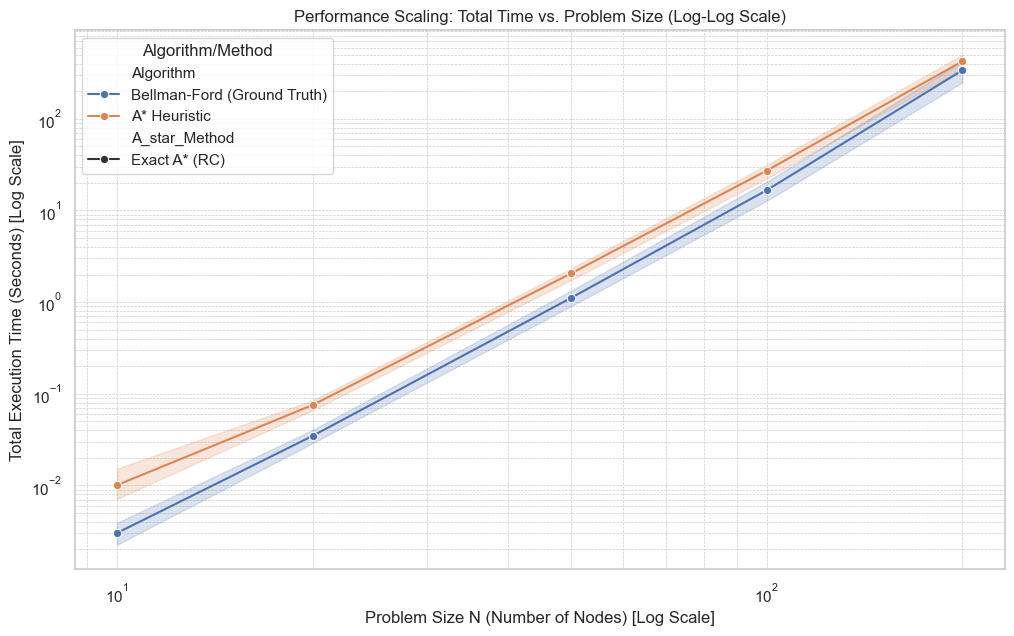

--------------------------------------------------
Generating Efficiency Plot (Exploration vs. Density)...


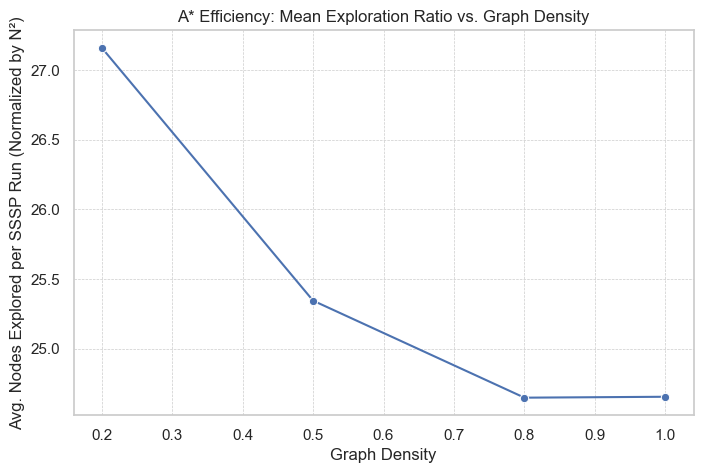

--------------------------------------------------
Generating Accuracy Plot (MAR vs. Size)...
Skipping Accuracy Plot: No approximation data found.
--------------------------------------------------


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
from typing import List, Dict, Any, Tuple

#Configuration
COMPARISON_FILE = "comparison_metrics.jsonl"
#Set Seaborn style for better visualization
sns.set_theme(style="whitegrid")

#Data Loading and Preparation

def load_comparison_data(filename: str = COMPARISON_FILE) -> pd.DataFrame:
    """Reads the comparison JSONL file, flattens the structure, and returns a DataFrame."""
    
    data_list = []
    
    if not os.path.exists(filename):
        print(f"Error: Comparison file not found at {filename}")
        return pd.DataFrame()

    with open(filename, 'r') as f:
        for line in f:
            if not line.strip(): continue
            try:
                data = json.loads(line)
                
                #Flatten the structure
                flat_data = {
                    'N': data['N'],
                    'approximation_used': data['approximation_used'],
                    'time_A_star_sec': data['time_A_star_sec'],
                    'time_BF_sec': data['time_BF_sec'],
                    'speedup_factor': data['speedup_factor'],
                    'nodes_explored_A_star': data['nodes_explored_A_star'],
                    'accuracy_rate': data['accuracy_rate'],
                    'mean_approx_ratio': data['mean_approx_ratio'],
                    'Size': data['parameters']['size'],
                    'Density': data['parameters']['density'],
                    'Noise_Level': data['parameters']['noise_level'],
                    'Negative': data['parameters']['negative_values'],
                }
                data_list.append(flat_data)
            except Exception as e:
                #Catch any loading or key errors and skip the line
                print(f"Skipping line due to error: {e}") 
                
    df = pd.DataFrame(data_list)
    
    #Ensure numerical types are correct
    numeric_cols = ['Size', 'Density', 'time_A_star_sec', 'time_BF_sec', 'mean_approx_ratio', 'speedup_factor']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    return df

#Load the data
df_results = load_comparison_data()

if df_results.empty:
    print("Cannot proceed with plotting: DataFrame is empty.")
    exit()

print(f"Data loaded successfully. Total runs: {len(df_results)}")
print("-" * 50)

#Plotting Functions

def plot_performance_vs_size(df):
    """
    Plot 1: Log-Log plot of Time vs. Problem Size (N) comparing all methods.
    """
    
    #Filter for non-negative runs for a clean comparison
    df_plot = df[df['Negative'] == False]
    
    #Create a column that identifies the specific A* method used
    df_plot['A_star_Method'] = df_plot.apply(
        lambda row: 'Hub-Based Approx' if row['approximation_used'] else 'Exact A* (RC)', axis=1
    )
    
    #Create long format for combined A* and BF plotting
    df_long = pd.melt(df_plot, 
                      id_vars=['Size', 'A_star_Method'], 
                      value_vars=['time_BF_sec', 'time_A_star_sec'],
                      var_name='Algorithm', 
                      value_name='Time (sec)')
    
    #Assign clear labels
    df_long['Algorithm'] = df_long['Algorithm'].replace({
        'time_BF_sec': 'Bellman-Ford (Ground Truth)',
        'time_A_star_sec': 'A* Heuristic'
    })

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_long,
        x='Size',
        y='Time (sec)',
        hue='Algorithm',
        style='A_star_Method', #Use the A* method to differentiate the lines
        marker='o',
        errorbar=('ci', 95)
    )
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('Performance Scaling: Total Time vs. Problem Size (Log-Log Scale)')
    plt.xlabel('Problem Size N (Number of Nodes) [Log Scale]')
    plt.ylabel('Total Execution Time (Seconds) [Log Scale]')
    plt.legend(title='Algorithm/Method', loc='upper left')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

# ---------------------------------------------------

def plot_efficiency_vs_density(df):
    """
    Plot 2: Efficiency (Nodes Explored Ratio) vs. Density.
    """
    
    #Calculate the ratio: Nodes Explored / Total possible SSSP runs (N * N)
    df['exploration_ratio'] = df['nodes_explored_A_star'] / (df['Size'] ** 2)
    
    #Group by density, calculating the mean ratio across all sizes
    df_plot = df.groupby('Density', as_index=False)['exploration_ratio'].mean()
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Density', y='exploration_ratio', data=df_plot, marker='o', errorbar=('ci', 95))
    
    plt.title('A* Efficiency: Mean Exploration Ratio vs. Graph Density')
    plt.xlabel('Graph Density')
    plt.ylabel('Avg. Nodes Explored per SSSP Run (Normalized by N²)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

# ---------------------------------------------------

def plot_accuracy_of_approximation(df):
    """
    Plot 3: Accuracy (Mean Approximation Ratio - MAR) vs. Size for approximation runs.
    """
    
    #Filter only the runs where approximation was used
    df_approx = df[df['approximation_used'] == True].copy()
    
    if df_approx.empty:
        print("Skipping Accuracy Plot: No approximation data found.")
        return
        
    plt.figure(figsize=(8, 6))
    
    #Use seaborn boxplot to show the distribution of approximation errors
    sns.boxplot(x='Size', y='mean_approx_ratio', hue='Density', data=df_approx, palette="viridis")
    
    plt.title('Approximation Quality: Mean Approximation Ratio (MAR)')
    plt.xlabel('Problem Size N (Approximation Runs)')
    plt.ylabel('Mean Approximation Ratio (MAR)')
    plt.legend(title='Density', loc='upper left')
    plt.grid(True, which="major", ls="--", linewidth=0.5)
    # Set ylim to focus on small errors (MAR should be near 0)
    plt.ylim(0, df_approx['mean_approx_ratio'].quantile(0.95) * 1.1) 
    plt.show()

#Run all Plots

print("Generating Performance Plot (Time vs. Size)...")
plot_performance_vs_size(df_results)
print("-" * 50)

print("Generating Efficiency Plot (Exploration vs. Density)...")
plot_efficiency_vs_density(df_results)
print("-" * 50)

print("Generating Accuracy Plot (MAR vs. Size)...")
plot_accuracy_of_approximation(df_results)
print("-" * 50)